# Heatmap Parameters Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import datetime

import numpy as np
import pandas as pd

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
import tensorflow as tf

# RANDOM_SEED = 250398
# tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.2
Num GPUs Available:  1


## Setup

In [4]:
%%time

ROOT_DIR = '../../../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path,
    ROOT_DIR,
    split=(0.8, 0.15, 0.05),
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../../../tmp\logs\20210511-080914
Wall time: 0 ns


## Analysis

Each experiment consistet of 10 images, 5 TP and 5 TN.

In [5]:
from os import listdir
from os.path import isfile, join

fpath = os.path.join(ROOT_DIR, "risei-history/heatmap-parameters--b2-value-0")

files = [f for f in listdir(fpath) if isfile(join(fpath, f))]
files[:5]

['hmap-parameters--deletion--m+1024-p1+0.25.cls',
 'hmap-parameters--deletion--m+1024-p1+0.3333333333333333.cls',
 'hmap-parameters--deletion--m+1024-p1+0.5.cls',
 'hmap-parameters--deletion--m+1024-p1+0.6666666666666666.cls',
 'hmap-parameters--deletion--m+1024-p1+0.75.cls']

In [6]:
import re


def parse(fname):
    p = re.compile("^hmap-parameters--(\w+)--m\+(\d+)-p1\+(\d+[.]?\d*)\.cls$")
    return p.match(fname).groups()

print(parse('hmap-parameters--deletion--m+1024-p1+0.6666666666666666.cls'))

('deletion', '1024', '0.6666666666666666')


In [7]:
from src.heatmaps.evaluation import HeatmapEvaluationHistory

data = {}


def append(key, value):
    if not key in data:
        data[key] = []
    data[key].append(value)

    
for fname in files:
    metric, masks_count, p1 = parse(fname)
    append('metric', metric)
    append('masks_count', int(masks_count))
    append('p1', float(p1))
    
    history = HeatmapEvaluationHistory.load(fpath, fname[:-4])
    desc = history._description()
    for key, value in desc.items():
        append(key, value)
    
    
df = pd.DataFrame(data=data)
df.head()

,metric,masks_count,p1,heatmaps,auc_mean,auc_p25,auc_median,auc_p75,auc_max,auc_min,auc_std
0,deletion,1024,0.250000,10,0.649712,0.635132,0.686637,0.708797,0.765139,0.410772,0.098614
1,deletion,1024,0.333333,10,0.643368,0.598627,0.643846,0.711018,0.746464,0.499782,0.077135
2,deletion,1024,0.500000,10,0.674387,0.639377,0.652944,0.712121,0.791653,0.605720,0.054341
3,deletion,1024,0.666667,10,0.696549,0.684787,0.709787,0.719024,0.796801,0.581419,0.055599
4,deletion,1024,0.750000,10,0.673616,0.625030,0.673777,0.716514,0.772723,0.589796,0.059095


In [8]:
def table(metric, value):
    df_m = df[df['metric'] == metric]
    df_m = df_m.sort_values('masks_count')
    return pd.pivot_table(df_m, values=value, index=["masks_count"], columns="p1", fill_value=0)

In [9]:
table('deletion', 'auc_median')

p1,0.250000,0.333333,0.500000,0.666667,0.750000
masks_count,,,,,
8,0.587406,0.560257,0.537045,0.579041,0.530529
16,0.586510,0.550912,0.517144,0.543406,0.528202
32,0.617772,0.589213,0.634701,0.622195,0.622499
64,0.605511,0.627161,0.648854,0.637362,0.606357
128,0.614635,0.599144,0.650838,0.620568,0.601672
256,0.665848,0.679780,0.668759,0.676215,0.587926
512,0.675962,0.660764,0.668481,0.713105,0.682327
1024,0.686637,0.643846,0.652944,0.709787,0.673777
2048,0.677393,0.645488,0.662798,0.718824,0.681363


In [10]:
table('insertion', 'auc_median')

p1,0.250000,0.333333,0.500000,0.666667,0.750000
masks_count,,,,,
8,0.577375,0.607119,0.565017,0.598045,0.624800
16,0.587338,0.621799,0.636231,0.625056,0.626285
32,0.598192,0.560026,0.550710,0.552673,0.570516
64,0.548836,0.535750,0.546540,0.515158,0.531583
128,0.569967,0.587399,0.591171,0.544097,0.520112
256,0.544671,0.505341,0.494440,0.508974,0.495576
512,0.542485,0.486957,0.472576,0.478954,0.459759
1024,0.518594,0.491493,0.473633,0.452452,0.444355
2048,0.524665,0.503283,0.477993,0.475226,0.450821


In [11]:
df_m = df.copy().sort_values("masks_count")
pd.pivot_table(df_m, values="auc_median", index=["masks_count"], columns=["p1", "metric"], fill_value=0)

p1           0.250000            0.333333            0.500000            \
metric       deletion insertion  deletion insertion  deletion insertion   
masks_count                                                               
8            0.587406  0.577375  0.560257  0.607119  0.537045  0.565017   
16           0.586510  0.587338  0.550912  0.621799  0.517144  0.636231   
32           0.617772  0.598192  0.589213  0.560026  0.634701  0.550710   
64           0.605511  0.548836  0.627161  0.535750  0.648854  0.546540   
128          0.614635  0.569967  0.599144  0.587399  0.650838  0.591171   
256          0.665848  0.544671  0.679780  0.505341  0.668759  0.494440   
512          0.675962  0.542485  0.660764  0.486957  0.668481  0.472576   
1024         0.686637  0.518594  0.643846  0.491493  0.652944  0.473633   
2048         0.677393  0.524665  0.645488  0.503283  0.662798  0.477993   
4096         0.680063  0.525253  0.655541  0.498184  0.661081  0.465332   

p1           0.666667            0.750000            
metric       deletion insertion  deletion insertion  
masks_count                                          
8            0.579041  0.598045  0.530529  0.624800  
16           0.543406  0.625056  0.528202  0.626285  
32           0.622195  0.552673  0.622499  0.570516  
64           0.637362  0.515158  0.606357  0.531583  
128          0.620568  0.544097  0.601672  0.520112  
256          0.676215  0.508974  0.587926  0.495576  
512          0.713105  0.478954  0.682327  0.459759  
1024         0.709787  0.452452  0.673777  0.444355  
2048         0.718824  0.475226  0.681363  0.450821  
4096         0.710274  0.466693  0.681162  0.454734

In [12]:
def map_p1(val):
    if val == 1/3:
        return 0.33
    if val == 2/3:
        return 0.66
    return val

def apply_fn(row):
#     print(row)
    if row['metric'] == 'deletion':
        row['auc_median'] = 1 - row['auc_median']
    row['p1'] = map_p1(row['p1'])
    return row

df_m = df.copy().sort_values("masks_count")
df_m = df_m.apply(apply_fn, axis=1)
p1_name = 'p'
masks_count_name = 'Počet masiek'
df_m = df_m.rename(columns={'p1': p1_name, 'masks_count': masks_count_name})

tt = pd.pivot_table(df_m, values="auc_median", index=[masks_count_name], columns=p1_name, fill_value=0) # value is mean of insertion and deletion auc_median
tt

p,0.25,0.33,0.50,0.66,0.75
Počet masiek,,,,,
8,0.494985,0.523431,0.513986,0.509502,0.547136
16,0.500414,0.535443,0.559543,0.540825,0.549041
32,0.490210,0.485406,0.458005,0.465239,0.474008
64,0.471662,0.454294,0.448843,0.438898,0.462613
128,0.477666,0.494127,0.470167,0.461764,0.459220
256,0.439412,0.412780,0.412840,0.416380,0.453825
512,0.433261,0.413097,0.402047,0.382925,0.388716
1024,0.415978,0.423823,0.410344,0.371332,0.385289
2048,0.423636,0.428898,0.407597,0.378201,0.384729


Text(0.5, 1.0, 'Kvalita tepelných máp metódy RISE\n(b1 = 0, b2 = 1, b2_value = 0) podľa počtu masiek\na miery prekrytia v maskách')

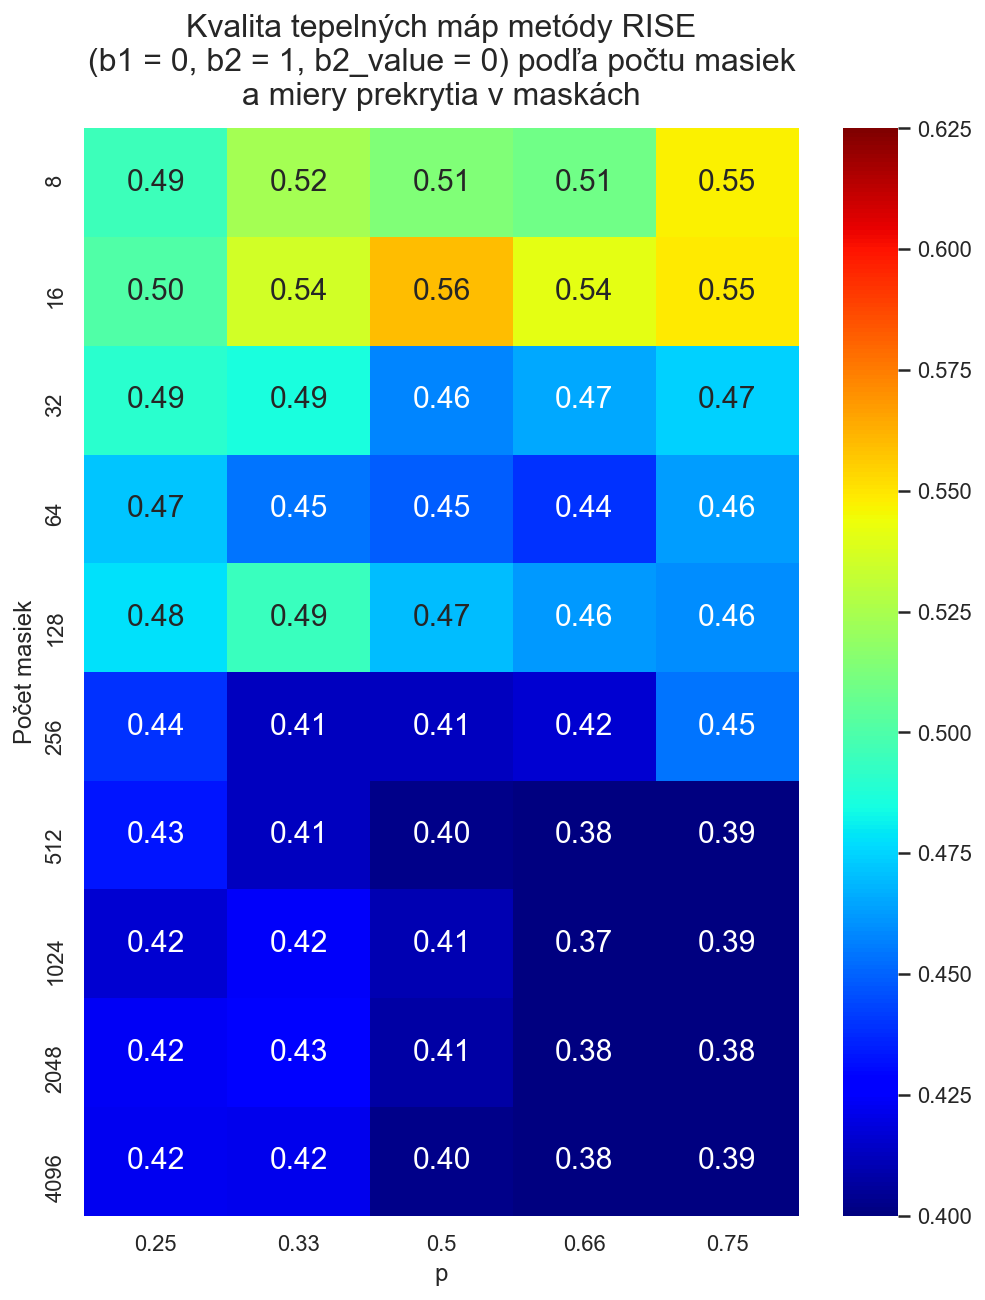

In [14]:
plt.rcParams['figure.figsize'] = (8, 10)
plt.rcParams['axes.titlesize'] = 16

ax = sns.heatmap(data=tt, annot=True, cmap='jet', vmin=0.40, vmax=0.625, fmt='.2f')
ax.set_title("Kvalita tepelných máp metódy RISE\n(b1 = 0, b2 = 1, b2_value = 0) podľa počtu masiek\na miery prekrytia v maskách", pad=12)